# K-Means Clustering for TOSP Codes

This notebook will be covering the following:  

*   Preprocessing a dataset of procedure descriptions
*   Calculation of text similarities
*   Performing of K-Means clustering
*   Identifying inconsistent procedure pairs

---

## **1. Import Libraries and Setup**

Importing the necessary libraries and downloading the required NLP resources.


In [44]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Download necessary NLP resources
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **2. Load Dataset**

Load the dataset of TOSP codes from the given CSV file.

In [40]:
df = pd.read_csv("combined_dataset.csv")
print("Dataset loaded successfully.")

Dataset loaded successfully.


## **3. Text Preprocessing**

Text under the 'Description' column will be preprocessed by converting it to lowercase, removing numbers and punctuation, and applying lemmatization and stopword removal.

In [41]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization & stopword removal
    return " ".join(words)

df["Cleaned_Description"] = df["Description"].apply(preprocess_text)

# Display sample of cleaned text
print("\nSample of cleaned descriptions:")
for i, text in enumerate(df["Cleaned_Description"].head(10)):
    print(f"Original: {df['Description'].iloc[i][:100]}...")
    print(f"Cleaned: {text[:100]}...")
    print("-" * 50)


Sample of cleaned descriptions:
Original: BOTULINUM TOXIN THERAPY FOR MOVEMENT DISORDERS...
Cleaned: botulinum toxin therapy movement disorder...
--------------------------------------------------
Original: BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (BILATERAL)...
Cleaned: breast ductal lesion microdochectomy bilateral...
--------------------------------------------------
Original: BREAST, DUCTAL LESIONS, MICRODOCHECTOMY (UNILATERAL)...
Cleaned: breast ductal lesion microdochectomy unilateral...
--------------------------------------------------
Original: BREAST, LUMPS, IMAGING GUIDED VACUUM ASSISTED BIOPSY, SINGLE LESION...
Cleaned: breast lump imaging guided vacuum assisted biopsy single lesion...
--------------------------------------------------
Original: BREAST, LUMP (REMOVAL) WITH PARENCHYMAL FLAP CLOSURE (UNILATERAL)...
Cleaned: breast lump removal parenchymal flap closure unilateral...
--------------------------------------------------
Original: BREAST, LUMPS, IMAGING GUIDED VACU

## **4. Text Similarity Calculation Using TF-IDF**

TF-IDF (Term Frequency-Inverse Document Frequency) values of the descriptions are calculated and pairwise cosine similarities are computed to identify highly similar procedure pairs.


In [42]:
# Text Similarity Using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df["Cleaned_Description"])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Identify highly similar procedure pairs
similar_pairs = [
    (df.iloc[i]["Code"], df.iloc[j]["Code"], cosine_sim[i, j])
    for i, j in combinations(range(len(df)), 2) if cosine_sim[i, j] > 0.8
]

similar_pairs_df = pd.DataFrame(similar_pairs, columns=["Code1", "Code2", "Similarity"])
print(f"Found {len(similar_pairs)} highly similar procedure pairs.")
similar_pairs_df.to_csv("highly_similar_procedure_pairs.csv", index=False)
print("Saved highly similar procedure pairs to highly_similar_procedure_pairs.csv.")


Found 536 highly similar procedure pairs.
Saved highly similar procedure pairs to highly_similar_procedure_pairs.csv.


## **5. K-Means Clustering**

K-Means clustering is then performed on the text descriptions. The optimal number of clusters (k) is deduced using the Silhouette Score method.


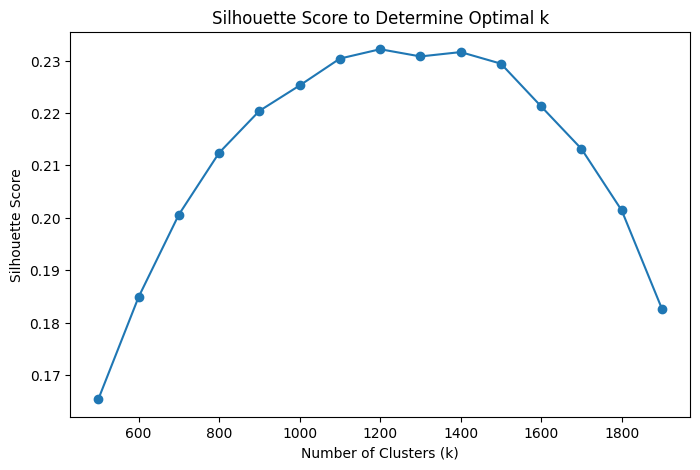

The optimal number of clusters based on Silhouette Score is: 1200


In [43]:
# Clustering (K-Means)
tfidf_dense = tfidf_matrix.toarray()

# Find optimal K using Silhouette Score
silhouette_scores = []
K_values = range(500, 2000, 100)  # Testing different k values

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_dense)
    score = silhouette_score(tfidf_dense, kmeans.labels_)
    silhouette_scores.append(score)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(K_values, silhouette_scores, marker="o", linestyle="-")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score to Determine Optimal k")
plt.show()

# Find the best k (the one with the highest silhouette score)
optimal_k = K_values[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters based on Silhouette Score is: {optimal_k}")


## **6. Perform K-Means with Optimal k**

Using the optimal number of clusters, we will then perform K-Means clustering and assign cluster labels to each procedure.


In [45]:
# Perform K-Means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df["KMeans_Cluster"] = kmeans.fit_predict(tfidf_dense)

## **7. Dimensionality Reduction Using PCA**




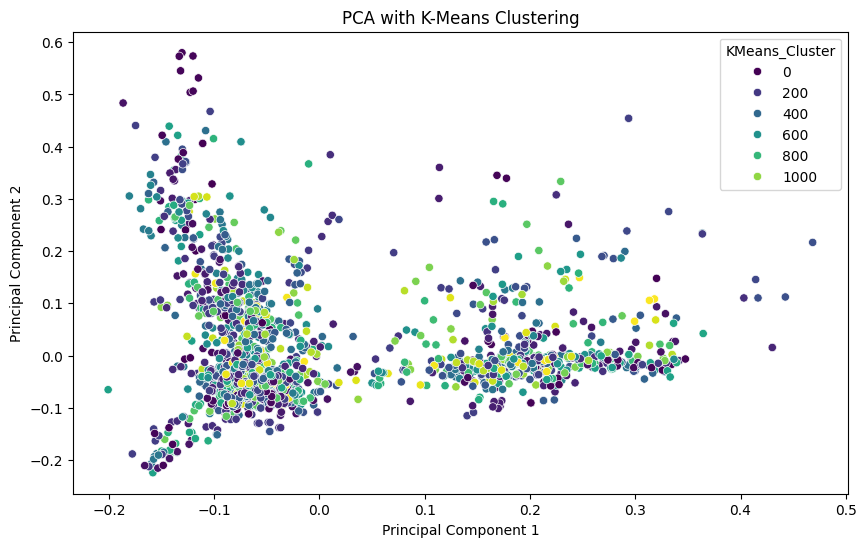

In [49]:
# Reduce dimensionality of TF-IDF matrix using PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_dense)

# Visualize the clusters in 2D space
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df["KMeans_Cluster"], palette="viridis")
plt.title("PCA with K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

## **8. Visualizing Clustering**

Here, we visualize the clustering results using a scatter plot. Each procedure will be assigned to a cluster.


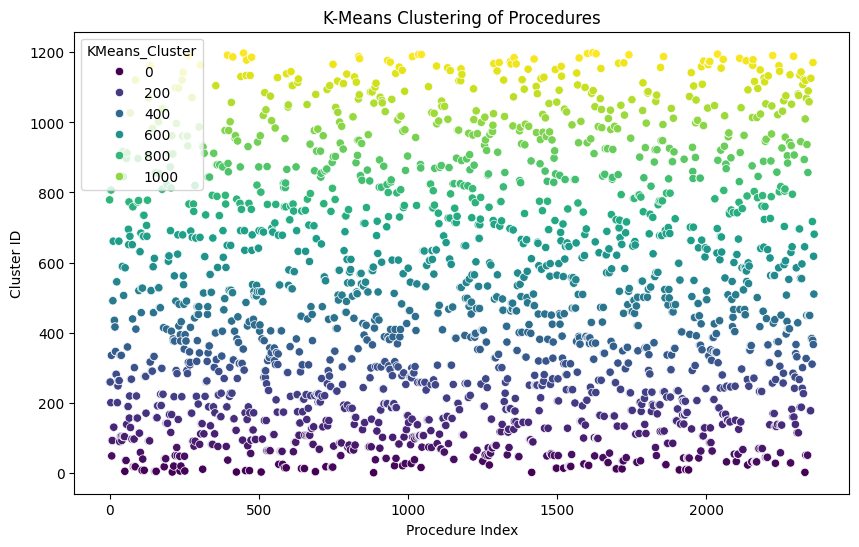

In [47]:
# Visualizing Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index, y=df["KMeans_Cluster"], hue=df["KMeans_Cluster"], palette="viridis")
plt.title("K-Means Clustering of Procedures")
plt.xlabel("Procedure Index")
plt.ylabel("Cluster ID")
plt.show()

## **9. Detecting Inconsistent Pairs**

Finally, we detect and save pairs of procedures within the same cluster but with low similarity (potentially inconsistent pairs).

In [48]:
# Detecting Inconsistent Pairs
df["Code_Index"] = df.index

# Merge cluster data
cluster_df = df[["Code", "KMeans_Cluster"]].copy()
cosine_sim_df = pd.DataFrame(cosine_sim, index=df["Code"], columns=df["Code"])

# Identify same-cluster pairs
same_cluster_pairs = pd.merge(cluster_df, cluster_df, on="KMeans_Cluster")
same_cluster_pairs = same_cluster_pairs[same_cluster_pairs["Code_x"] != same_cluster_pairs["Code_y"]]

# Add similarity scores
same_cluster_pairs["Similarity"] = same_cluster_pairs.apply(
    lambda row: cosine_sim_df.loc[row["Code_x"], row["Code_y"]], axis=1
)

# Filter inconsistent pairs
inconsistent_pairs = same_cluster_pairs[same_cluster_pairs["Similarity"] < 0.2]

print(f"Found {len(inconsistent_pairs)} potentially inconsistent procedure pairs.")
inconsistent_pairs.to_csv("inconsistent_tosp_pairs.csv", index=False)
print("Results saved to inconsistent_tosp_pairs.csv")

Found 60 potentially inconsistent procedure pairs.
Results saved to inconsistent_tosp_pairs.csv
